# VQE Demo

VQE demo with pennylane.

## VQE demo with molecular data

In [5]:
import numpy as np

def func_one(x):
    return 3 * x * (1 - x) ** 2 + (1 - x) ** 3

def func_two(x):
    return 3 * x * (1 - x) ** 2

nums = np.arange(0.1, 0.7, 0.1)

for i in nums:
    print(i, func_one(i))
    print(i, func_two(i))
    print("")

0.1 0.9720000000000002
0.1 0.24300000000000005

0.2 0.8960000000000002
0.2 0.3840000000000001

0.30000000000000004 0.7839999999999999
0.30000000000000004 0.441

0.4 0.648
0.4 0.43200000000000005

0.5 0.5
0.5 0.375

0.6 0.35200000000000004
0.6 0.28800000000000003



(<Figure size 432x288 with 1 Axes>, <Axes:>)
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
(<Figure size 432x288 with 1 Axes>, <Axes:>)
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


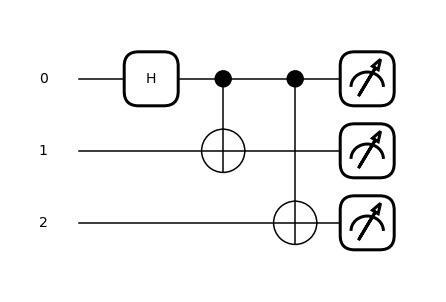

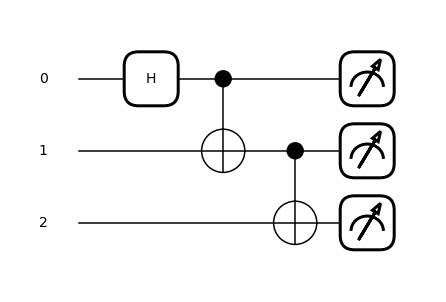

In [19]:
import pennylane as qml

dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit_one():
    qml.Hadamard(wires=0)
    qml.CNOT([0, 1])
    qml.CNOT([1, 2])

    return qml.state()

@qml.qnode(dev)
def circuit_two():
    qml.Hadamard(wires=0)
    qml.CNOT([0, 1])
    qml.CNOT([0, 2])

    return qml.state()

print(qml.draw_mpl(circuit_two)())
print(circuit_two())

print(qml.draw_mpl(circuit_one)())
print(circuit_one())

In [25]:
from pennylane import numpy as np
import pennylane as qml
import catalyst

import jax
import jax.numpy as jnp
import optax

In [26]:
dataset = qml.data.load("qchem", molname="H2", bondlength=0.5, basis="STO-3G", attributes=["fci_energy", "hamiltonian", "molecule"])[0]
H, qubits, fci_energy, num_electrons = dataset.hamiltonian, len(dataset.hamiltonian.wires), dataset.fci_energy, dataset.molecule.n_electrons
data = {"hamiltonian":H, "num_qubits":qubits, "fci_energy":fci_energy, "num_electrons":num_electrons}
data

{'hamiltonian': (
     0.3798283098637154 * I(0)
   + 0.21393510353947193 * Z(0)
   + 0.21393510353947195 * Z(1)
   + 0.17992646419676706 * (Z(0) @ Z(1))
   + 0.04221756865425247 * (Y(0) @ X(1) @ X(2) @ Y(3))
   + -0.04221756865425247 * (Y(0) @ Y(1) @ X(2) @ X(3))
   + -0.04221756865425247 * (X(0) @ X(1) @ Y(2) @ Y(3))
   + 0.04221756865425247 * (X(0) @ Y(1) @ Y(2) @ X(3))
   + -0.36914351602212087 * Z(2)
   + 0.1345923440860462 * (Z(0) @ Z(2))
   + -0.3691435160221209 * Z(3)
   + 0.17680991274029867 * (Z(0) @ Z(3))
   + 0.17680991274029867 * (Z(1) @ Z(2))
   + 0.1345923440860462 * (Z(1) @ Z(3))
   + 0.18620978863195248 * (Z(2) @ Z(3))
 ),
 'num_qubits': 4,
 'fci_energy': -1.0551607375072107,
 'num_electrons': 2}

In [3]:
def calculate_params_one_line_hea(num_layers):
    num_params_per_rotation_block = 3
    num_params = num_params_per_rotation_block * num_layers
    return num_params

def create_hea_params(num_qubits, num_layers):
    key = jax.random.PRNGKey(0)
    num_params = calculate_params_one_line_hea(num_layers)
    shape = (num_qubits, num_params)
    circuit_weights = jax.random.normal(key, shape) * -0.1
    return circuit_weights

In [27]:
# Setup
device_name = "lightning.qubit"
hamiltonian = data["hamiltonian"]
num_electrons = data["num_electrons"]
num_qubits = data["num_qubits"]
num_layers = 1

dev = qml.device(device_name, wires=num_qubits)
hf_state = jnp.array(qml.qchem.hf_state(num_electrons, num_qubits))

# print(type(hf_state))

circuit_parameters = create_hea_params(num_qubits, num_layers)
circuit_parameters

Array([[-0.03675396,  0.0908204 ,  0.20064399],
       [-0.01605628, -0.01323345,  0.13054345],
       [ 0.04055676,  0.17935351,  0.13566547],
       [-0.08095846,  0.03797796, -0.00844285]], dtype=float64)

In [31]:
def create_layer(num_qubits, params, layer_number):
    """Create a layer which consists of rotation gates with alternating
    cnot gates. Number of qubits must be minimum 4.
    
    Args:
        num_qubits (int): The number of qubits.
        params (torch.Tensor): The parameters of the rotation gates.
        layer_number (int): The current layer number of this section.
        
    Returns:
        () A layer which is just a quantum circuit; a smaller section of a larger quantum circuit."""
    
    rx_param_value = (layer_number * 3) - 3
    ry_param_value = (layer_number * 3) - 2
    rz_param_value = (layer_number * 3) - 1

    for i in range(num_qubits):
        qml.RX(params[i, rx_param_value], wires=i)
        qml.RY(params[i, ry_param_value], wires=i)
        qml.RZ(params[i, rz_param_value], wires=i)

    # First alternating CNOT gate layer.
    for i in range(0, num_qubits - 1, 2):
        qml.CNOT(wires=[i, i+1])
    
    # Add identity if space so rotation gates all aligned.
    if i + 1 < num_qubits:
        qml.Identity(num_qubits - 1)

    qml.Identity(0)

    # Second alternating CNOT gate layer.
    for i in range(1, num_qubits - 1, 2):
        qml.CNOT(wires=[i, i+1])

@qml.qjit(autograph=True)
@qml.qnode(device=dev, wires=num_qubits)
def hea_circuit(circuit_parameters):
    """Create a quantum circuit with a hardware efficient ansatz.
    
    Args:
        master_dictionary (dict): A dictionary which holds all inputs values.
            This includes molecular dataset, ansatz inputs and yaml parameters.
            
    Returns:
        (torch.Tensor.float) The expectation value of the Hamiltonian."""
    
    for i in range(num_layers):
        create_layer(num_qubits, circuit_parameters, i)
    return qml.expval(H)

/home/hoawenlo/.local/lib/python3.10/site-packages/pennylane/workflow/qnode.py:518: UserWarning: Received gradient_kwarg wires, which is not included in the list of standard qnode gradient kwargs.
  warnings.warn(


(<Figure size 576x360 with 1 Axes>, <Axes:>)


/home/hoawenlo/.local/lib/python3.10/site-packages/catalyst/autograph/ag_primitives.py:347: UserWarning: Tracing of an AutoGraph converted for loop failed with an exception:
  AutoGraphError:    The variable 'i' is potentially uninitialized:
     - you may have forgotten to initialize it prior to accessing it inside a loop, or
     - you may be attempting to access a variable local to the body of a loop in an outer scope.
    Please ensure 'i' is initialized with a value before entering the loop.

The error ocurred within the body of the following for loop statement:
  File "/tmp/ipykernel_77199/1082879077.py", line 23, in create_layer
    for i in range(0, num_qubits - 1, 2):

If you intended for the conversion to happen, make sure that the (now dynamic) loop variable is not used in tracing-incompatible ways, for instance by indexing a Python list with it. In that case, the list should be wrapped into an array.
To understand different types of JAX tracing errors, please refer to the g

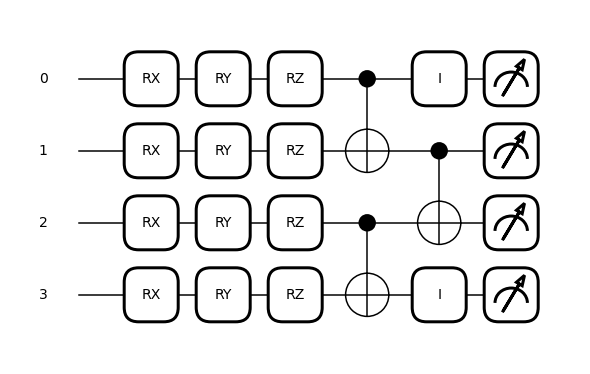

In [32]:
print(qml.draw_mpl(hea_circuit)(circuit_parameters))

In [33]:
circuit_parameters = create_hea_params(num_qubits, num_layers)
current_cost = hea_circuit(circuit_parameters)

/home/hoawenlo/.local/lib/python3.10/site-packages/catalyst/autograph/ag_primitives.py:347: UserWarning: Tracing of an AutoGraph converted for loop failed with an exception:
  AutoGraphError:    The variable 'i' is potentially uninitialized:
     - you may have forgotten to initialize it prior to accessing it inside a loop, or
     - you may be attempting to access a variable local to the body of a loop in an outer scope.
    Please ensure 'i' is initialized with a value before entering the loop.

The error ocurred within the body of the following for loop statement:
  File "/tmp/ipykernel_77199/1082879077.py", line 23, in create_layer
    for i in range(0, num_qubits - 1, 2):

If you intended for the conversion to happen, make sure that the (now dynamic) loop variable is not used in tracing-incompatible ways, for instance by indexing a Python list with it. In that case, the list should be wrapped into an array.
To understand different types of JAX tracing errors, please refer to the g

In [36]:
opt = optax.sgd(learning_rate=0.4)

@qml.qjit
def update_step(params, opt_state):
    grads = catalyst.grad(test_circuit)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state)

def optimisation():
    circuit_parameters = create_hea_params(num_qubits, num_layers)
    
    state = opt.init(circuit_parameters)
    
    # Optimization loop
    for i in range(30):
        circuit_parameters, state = update_step(circuit_parameters, state)
        
        # Compute and print the current cost
        current_cost = hea_circuit(circuit_parameters)
        print(f"Iteration {i+1}, Cost: {current_cost}")

In [37]:
optimisation()

Iteration 1, Cost: 1.0554376878563574
Iteration 2, Cost: 1.0532182771478933
Iteration 3, Cost: 1.050043995610355
Iteration 4, Cost: 1.0454623475042057
Iteration 5, Cost: 1.0388240853266282
Iteration 6, Cost: 1.0292132951457627
Iteration 7, Cost: 1.0153707777551173
Iteration 8, Cost: 0.9956323011139191
Iteration 9, Cost: 0.9679289400446892
Iteration 10, Cost: 0.9299305541530465
Iteration 11, Cost: 0.8794322668106429
Iteration 12, Cost: 0.8150281952633472
Iteration 13, Cost: 0.7369149564625193
Iteration 14, Cost: 0.6473706384312179
Iteration 15, Cost: 0.5504076805312054
Iteration 16, Cost: 0.4506865134320199
Iteration 17, Cost: 0.3525780901598364
Iteration 18, Cost: 0.2600763366819264
Iteration 19, Cost: 0.17704374191882846
Iteration 20, Cost: 0.10678746797199129
Iteration 21, Cost: 0.05103032564044916
Iteration 22, Cost: 0.009336728860382844
Iteration 23, Cost: -0.020433232287206518
Iteration 24, Cost: -0.04111731320148524
Iteration 25, Cost: -0.055409551951567916
Iteration 26, Cost: -0

qubits: 4
4
[[-0.03675396  0.0908204   0.20064399]
 [-0.01605628 -0.01323345  0.13054345]
 [ 0.04055676  0.17935351  0.13566547]
 [-0.08095846  0.03797796 -0.00844285]]
(<Figure size 576x360 with 1 Axes>, <Axes:>)
--- Step: 0, Energy: 0.70531468
--- Step: 1, Energy: 0.70263679
--- Step: 2, Energy: 0.69878569
--- Step: 3, Energy: 0.69321684
--- Step: 4, Energy: 0.68514717
--- Step: 5, Energy: 0.67347364
--- Step: 6, Energy: 0.65669117
--- Step: 7, Energy: 0.63284462
--- Step: 8, Energy: 0.59958421
--- Step: 9, Energy: 0.55443012


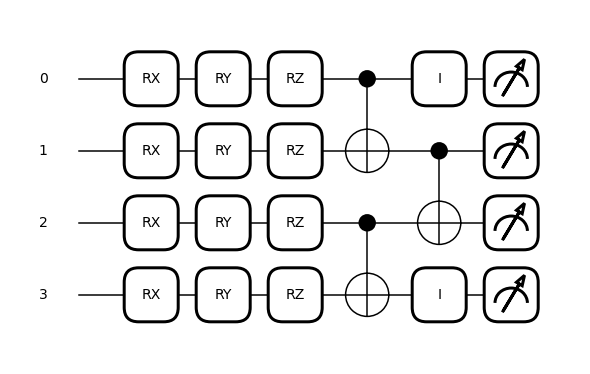

In [24]:
import pennylane as qml
from pennylane import numpy as np

dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

print(f"qubits: {qubits}")
print(len(dataset.hamiltonian.wires))
from jax import numpy as jnp

hf = jnp.array(dataset.hf_state)
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qjit
@qml.qnode(dev)
def cost(params):
    return test_circuit(params)
init_params = create_hea_params(qubits, 1)
print(init_params)
print(qml.draw_mpl(test_circuit)(init_params))
import catalyst
import optax

opt = optax.sgd(learning_rate=0.4)

@qml.qjit
def update_step(i, params, opt_state):
    """Perform a single gradient update step"""
    grads = catalyst.grad(test_circuit)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state)

loss_history = []

opt_state = opt.init(init_params)
params = init_params

for i in range(10):
    params, opt_state = update_step(i, params, opt_state)
    loss_val = cost(params)

    print(f"--- Step: {i}, Energy: {loss_val:.8f}")

    loss_history.append(loss_val)

# uccsd implementation

In [2]:
symbols  = ['H', 'H', 'H']
geometry = np.array([[0.01076341,  0.04449877,  0.0],
                     [0.98729513,  1.63059094,  0.0],
                     [1.87262415, -0.00815842,  0.0]], requires_grad = False)

In [3]:
electrons = 2
charge = 1

H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, charge=charge)
H, qubits

((
     -0.2997597743754067 * I(0)
   + 0.21445351986388553 * Z(0)
   + -1.0257464398699678e-08 * (Y(0) @ Z(1) @ Y(2))
   + -1.0257464398699678e-08 * (X(0) @ Z(1) @ X(2))
   + 1.0236350002010286e-08 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4))
   + 1.0236350002010286e-08 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4))
   + -0.11490113702048388 * Z(2)
   + 0.10696152091490654 * (Z(0) @ Z(2))
   + -0.1149015987674627 * Z(4)
   + 0.10696156152403857 * (Z(0) @ Z(4))
   + 0.2144535198638854 * Z(1)
   + 0.14703077800528846 * (Z(0) @ Z(1))
   + 2.5884670622200456e-08 * (Y(0) @ Y(2))
   + 2.5884670622200456e-08 * (X(0) @ X(2))
   + -2.5831233964757755e-08 * (Y(0) @ Z(2) @ Z(3) @ Y(4))
   + -2.5831233964757755e-08 * (X(0) @ Z(2) @ Z(3) @ X(4))
   + -1.025746439956704e-08 * (Y(1) @ Z(2) @ Y(3))
   + 2.5884670622200456e-08 * (Z(0) @ Y(1) @ Z(2) @ Y(3))
   + -1.025746439956704e-08 * (X(1) @ Z(2) @ X(3))
   + 2.5884670622200456e-08 * (Z(0) @ X(1) @ Z(2) @ X(3))
   + 0.03599968053401326 * (Y(0) @ X(1) @ X(2) @ Y(3))
 

In [6]:
hf_state = qml.qchem.hf_state(electrons, qubits)
hf_state

array([1, 1, 0, 0, 0, 0])

In [7]:
singles, doubles = qml.qchem.excitations(electrons, qubits)
singles, doubles

([[0, 2], [0, 4], [1, 3], [1, 5]],
 [[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 3, 4], [0, 1, 4, 5]])

In [13]:
singles, doubles = qml.qchem.excitations(electrons, qubits)
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
print(singles, s_wires)

[[0, 2], [0, 4], [1, 3], [1, 5]] [[0, 1, 2], [0, 1, 2, 3, 4], [1, 2, 3], [1, 2, 3, 4, 5]]


In [12]:
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
d_wires

[[[0, 1], [2, 3]], [[0, 1], [2, 3, 4, 5]], [[0, 1], [3, 4]], [[0, 1], [4, 5]]]

(<Figure size 288x504 with 1 Axes>, <Axes:>)


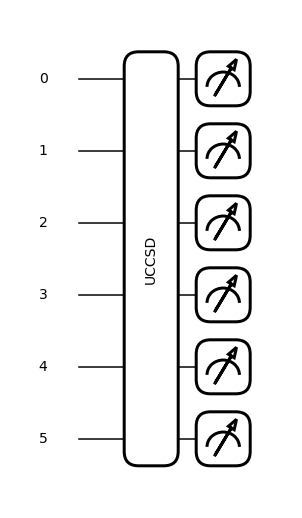

In [10]:
dev = qml.device("default.qubit", wires=qubits)

# Define the qnode
@qml.qnode(dev)
def circuit(params, wires, s_wires, d_wires, hf_state):
    qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
    return qml.expval(H)

params = np.zeros(len(singles) + len(doubles))
wires=range(qubits)
print(qml.draw_mpl(circuit)(params, wires, s_wires, d_wires, hf_state))

In [14]:
optimizer = qml.GradientDescentOptimizer(stepsize=0.5)

# Optimize the circuit parameters and compute the energy
for n in range(21):
    params, energy = optimizer.step_and_cost(circuit, params,
    wires=range(qubits), s_wires=s_wires, d_wires=d_wires, hf_state=hf_state)
    if n % 2 == 0:
        print("step = {:},  E = {:.8f} Ha".format(n, energy))

step = 0,  E = -1.24654994 Ha
step = 2,  E = -1.27016844 Ha
step = 4,  E = -1.27379541 Ha
step = 6,  E = -1.27434106 Ha
step = 8,  E = -1.27442311 Ha
step = 10,  E = -1.27443547 Ha
step = 12,  E = -1.27443733 Ha
step = 14,  E = -1.27443761 Ha
step = 16,  E = -1.27443765 Ha
step = 18,  E = -1.27443766 Ha
step = 20,  E = -1.27443766 Ha


# Jit

In [6]:
import pennylane as qml
from catalyst import qjit
from jax import numpy as jnp

dev = qml.device("lightning.qubit", wires=3, shots=1000)

@qjit
@qml.qnode(dev)
def circuit(x, y, z):
    qml.RX(jnp.sin(x), wires=[y + 1])
    qml.RY(x ** 2, wires=[z])
    qml.CNOT(wires=[y, z])
    return qml.probs(wires=[y + 1])

print(qml.draw(circuit)(1.072, 1, 2))

1: ─────────────────────╭●─┤       
2: ──RX(0.88)──RY(1.15)─╰X─┤  Probs


In [7]:
circuit(1.072, 1, 2)

array([0.642, 0.358])

In [8]:
circuit(2.65, 0, 2)

array([0.951, 0.049])

# Testing for main

In [5]:
%load_ext autoreload
%autoreload 2

In [20]:
%cd /home/hoawenlo/Programming/Python/VQE-pennylane-demo

from run_pipeline import run_pipeline

results, variational_circuit_params, loss = run_pipeline("params.yaml")

/home/hoawenlo/Programming/Python/VQE-pennylane-demo
Epoch 1: Loss = 1.26444014 Ha, Theta = [[ 0.31216192  0.2519293  -0.13204733  0.163806    0.22675322 -0.13723812
  -0.01804417 -0.01163291 -0.00905043  0.18656093  0.09422024  0.09395999
   0.26977158  0.2969156  -0.23674008]
 [-0.09538934  0.23852591  0.13350122  0.1377557  -0.09860618 -0.16201612
   0.13559793  0.10085362 -0.12345874  0.18013391 -0.2531991  -0.09052511
   0.06076502  0.24261013 -0.06128502]
 [-0.17094979 -0.15288043 -0.12815183  0.13200909 -0.15803088 -0.11799525
  -0.11307447 -0.25064218 -0.143846   -0.04244867  0.13116963 -0.06224074
   0.21536848 -0.05530157 -0.327799  ]
 [-0.11328802  0.20186864 -0.03626398 -0.19422153 -0.02914289 -0.22306931
  -0.11314602  0.04541387 -0.35654813 -0.1756539   0.02847356  0.0064742
  -0.15374239 -0.12017129 -0.15960781]]
Epoch 2: Loss = 1.07857179 Ha, Theta = [[ 0.41213676  0.35199925 -0.1320313   0.26210907  0.32361078 -0.07976173
  -0.09147032  0.04868224  0.05047115  0.285163

/home/hoawenlo/.local/lib/python3.10/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch 3: Loss = 0.74132077 Ha, Theta = [[ 0.51237535  0.4521932  -0.0778387   0.3572859   0.42151746 -0.00205804
  -0.17639011  0.12254469  0.12872116  0.38315398  0.07072535  0.1676476
   0.4692955   0.4890252  -0.12165085]
 [-0.2698969   0.43343055  0.19992362  0.30188692 -0.20791402 -0.30363038
   0.2599716   0.26748526  0.01093978  0.36610234 -0.4287308  -0.23690823
   0.2550082   0.4209237  -0.13333969]
 [-0.3441243  -0.32253814 -0.26948345 -0.00451201 -0.0571869  -0.2902788
  -0.28866318 -0.13008049 -0.21636775 -0.18115568  0.21273999 -0.16422462
   0.09328107 -0.02433221 -0.4257102 ]
 [-0.04062422  0.35936707 -0.16644767 -0.11903112  0.03923017 -0.27836218
  -0.03274454 -0.01902083 -0.46227112 -0.09305489 -0.01976786  0.08016081
  -0.07931256 -0.25461692 -0.08933192]]
Epoch 4: Loss = 0.37664808 Ha, Theta = [[ 0.6129099   0.5527379  -0.04979414  0.45406395  0.52055246  0.08109651
  -0.23666894  0.17448695  0.21230677  0.4818051   0.01468988  0.12076932
   0.5693524   0.58687377 -

In [15]:
# Load in dataset for methane molecule.
dataset = qml.data.load("qchem", molname="CH2", bondlength=1.085, basis="STO-3G", attributes=["fci_energy", "hamiltonian", "molecule"])

In [23]:
dataset[0].molecule.n_electrons

8

In [4]:
# Construct hamiltonian.
H, qubits = dataset[0].hamiltonian, len(dataset[0].hamiltonian.wires)
print(f"Number of qubits: {qubits}")
print(f"Hamiltonian: {H}")

Number of qubits: 14
Hamiltonian: -24.01803924608539 * I(0) + 6.292442523016621 * Z(0) + 0.06846266470057542 * (Y(0) @ Z(1) @ Y(2)) + 0.06846266470057542 * (X(0) @ Z(1) @ X(2)) + 0.020282064285863835 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.020282064285863835 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.05622447382692242 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10)) + 0.05622447382692242 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ X(10)) + 6.292442523016617 * Z(1) + 0.06846266470057538 * (Y(1) @ Z(2) @ Y(3)) + 0.06846266470057538 * (X(1) @ Z(2) @ X(3)) + 0.020282064285863818 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Y(7)) + 0.020282064285863818 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ X(7)) + 0.05622447382692237 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Y(11)) + 0.05622447382692237 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ X(11)) 

In [6]:
# Lets prepare the quantum circuit ansatz.
# We will prepare a quantum state with a 4 qubit Jordan Wigner representation
# with two states, one with both electrons in the ground state, and one with the
# electrons both in excited state.
# We can setup a hartree fock state which will be our starting point of the 
# vqe. We will use the hf state to form our quantum register.
electrons = 10
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [26]:
def methane_ansatz(params, wires):
    if len(params) != wires:
        raise ValueError(f"Number of parameters does not match number of qubits.")

    for i in range(wires):
        # Assign the parameter to parameterised rotation X gate for each qubit.
        qml.RX(params[i], wires=i)
    for i in range(wires):
        # Assign the parameter to parameterised rotation X gate for each qubit.
        qml.RY(params[i], wires=i)
    for i in range(wires - 1):
        # Assign CNOT gate where first qubit is control qubit and second qubit is target qubit.
        qml.CNOT(wires=[i, i + 1])

# Circuit ansatz.
@qml.qnode(dev, interface="torch")
def circuit(params, hartree_fock_state, hamiltonian, num_wires):
    qml.BasisState(hartree_fock_state, wires=range(num_wires))
    methane_ansatz(params, num_wires)
    return qml.expval(hamiltonian)

# Cost function is simply the expectation value.
def cost_fn(params, hartree_fock_state, hamiltonian, qubits):
    return circuit(params, hartree_fock_state, hamiltonian, qubits)

Parameter containing:
tensor([ 0.1401, -0.2059, -0.0284, -0.0022,  0.0347,  0.0416,  0.1203, -0.0684,
         0.1195,  0.0715,  0.0044,  0.0504,  0.0111,  0.1923],
       requires_grad=True) 



C:\Users\Hoawen\AppData\Local\Temp\ipykernel_7348\1675933613.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


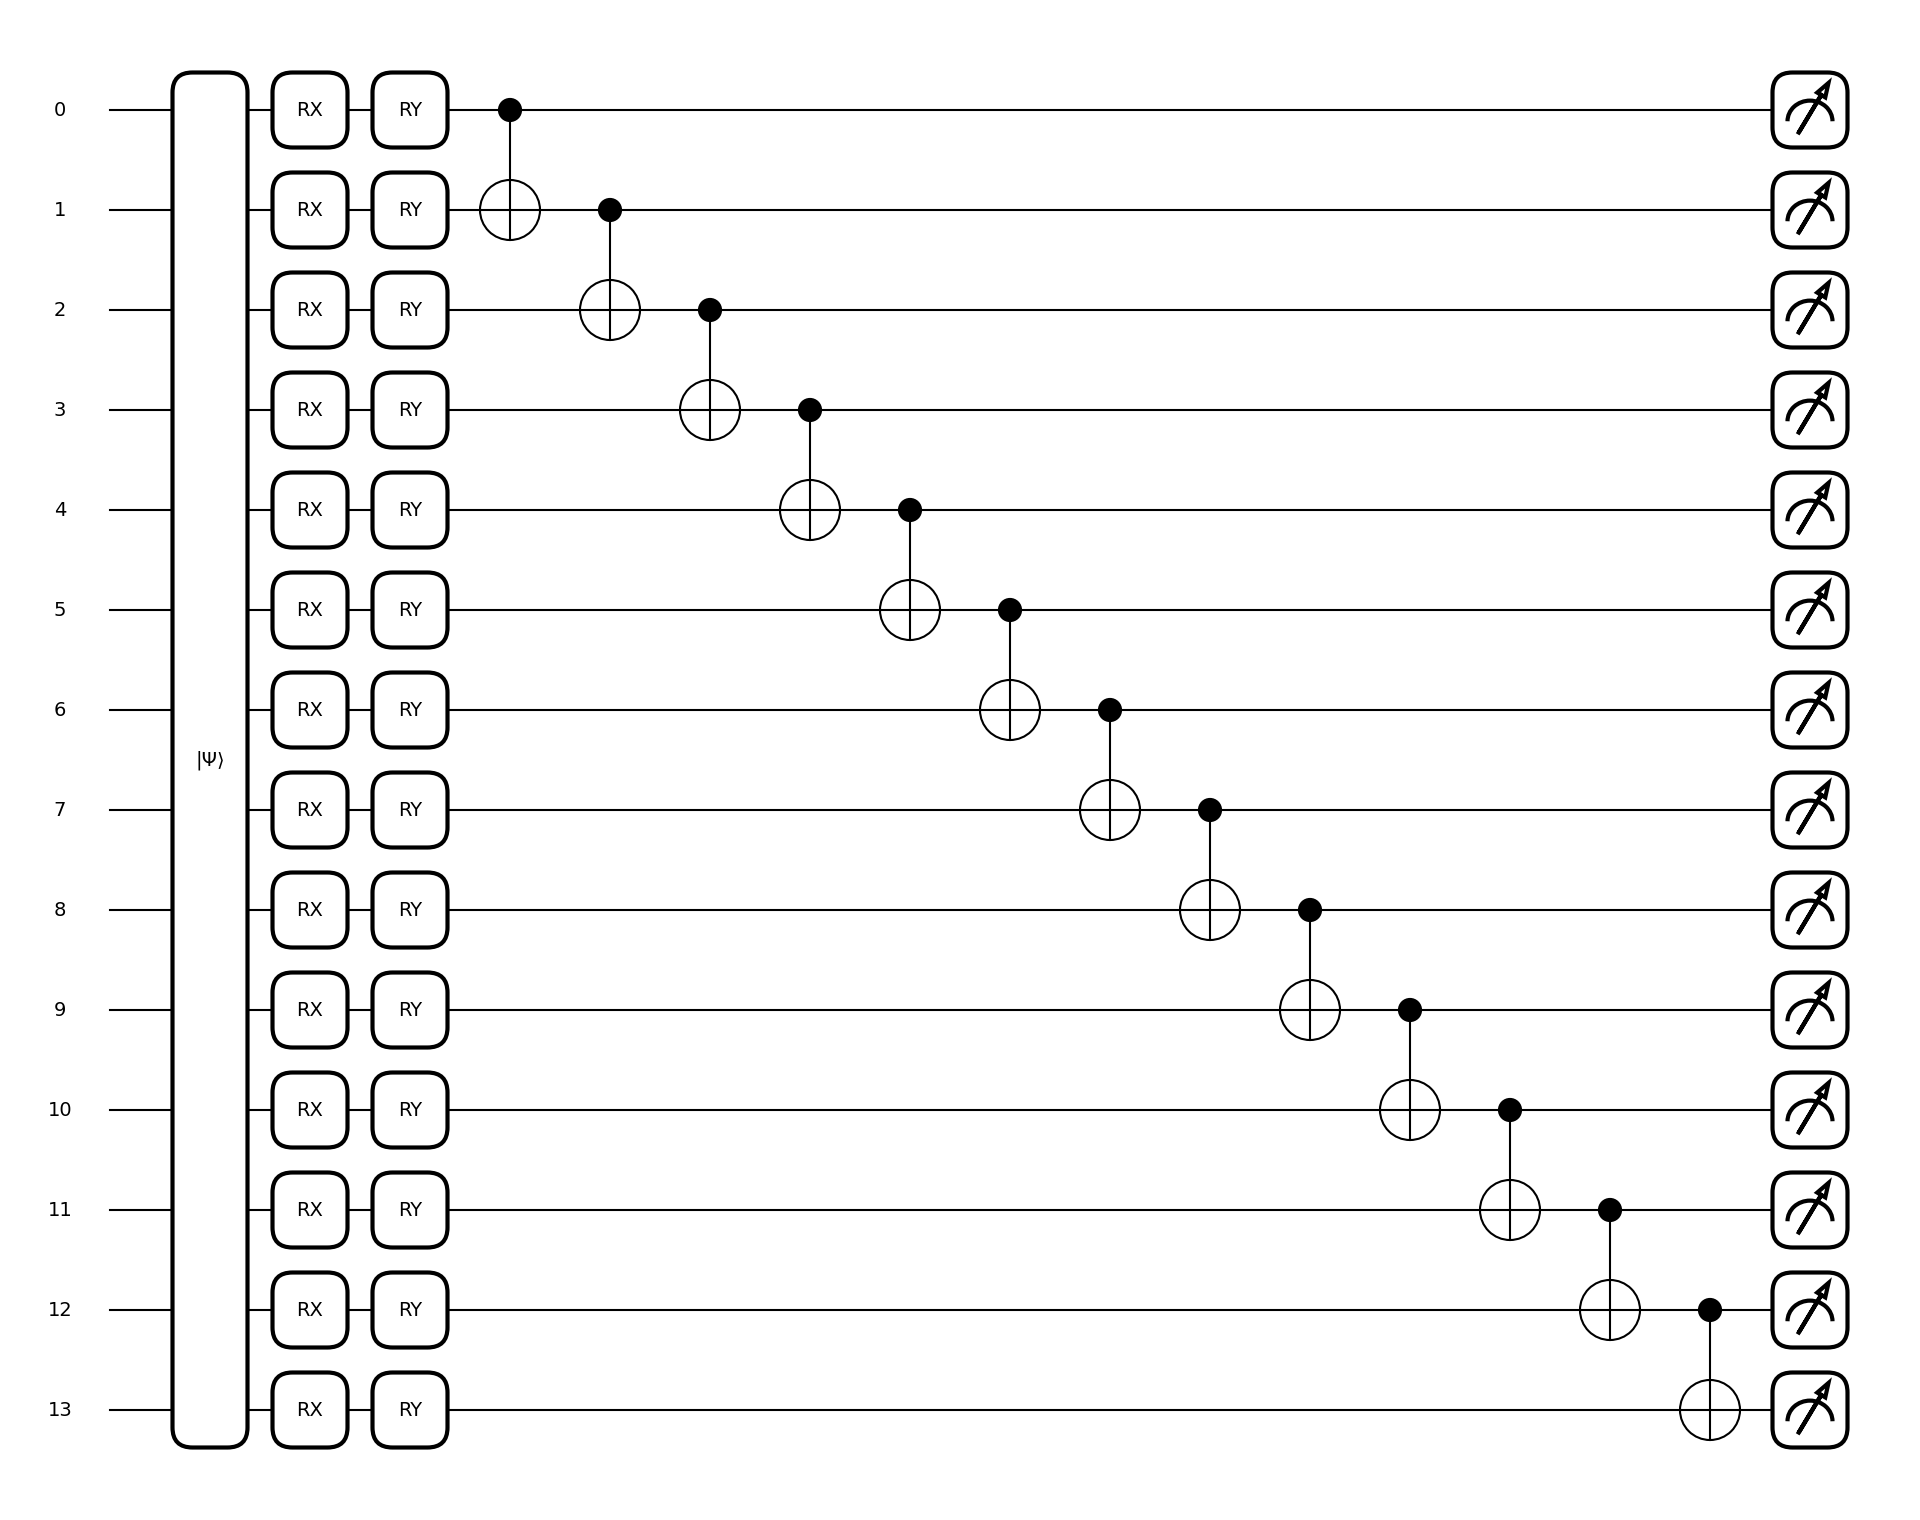

In [27]:
# Initialise container to store results
results = {"theta_param":[], 
           "energy_expectation_value":[]}


# Intialise theta parameter.
theta_value = torch.randn(qubits, requires_grad=True) * 0.1
theta_param = torch.nn.Parameter(theta_value)
print(theta_param, "\n")

# Draw circuit
fig, ax = qml.draw_mpl(circuit)(theta_param, hf, H, qubits)
plt.tight_layout()
plt.show()

# Initialise optimiser
opt = torch.optim.Adam([theta_param], lr=0.5)

In [28]:
# Training loop
epochs = 30
for i in range(epochs):
    # Ensure gradients are zero
    opt.zero_grad()

    # Run both the forward pass and calculate the cost function.
    # Remember cost function is the expectation value.
    loss = cost_fn(theta_param, hf, H, qubits)
    
    # Backpropagate.
    loss.backward()
    
    # Update parameters.
    opt.step()

    parameter_value = theta_param.clone().detach().numpy()

    results["theta_param"].append(parameter_value)
    results["energy_expectation_value"].append(loss.detach().numpy())

    print(f"Epoch {i + 1}: Loss = {loss.item():.8f} Ha, Theta = {theta_param.detach().numpy()}")

print(f"Final parameters: {theta_param}")
print(f"Final cost: {cost_fn(theta_param, hf, H, qubits).item():.4f}")

Epoch 1: Loss = -24.88184148 Ha, Theta = [ 0.640125   -0.7059268  -0.52844036 -0.5022109   0.5346563  -0.4583477
  0.6203493  -0.56836563  0.61948264  0.57145286  0.5043746   0.5503995
  0.5110689   0.69225645]
Epoch 2: Loss = -26.32410268 Ha, Theta = [ 0.27049753 -1.2003444  -0.21923897 -0.89383316  0.19438228 -0.08872876
  0.71432024 -0.1992414   1.0855043   0.2068479   0.88345194  0.9712584
  0.896947    1.1670208 ]
Epoch 3: Loss = -29.78849962 Ha, Theta = [-0.15799344 -1.6982892   0.1400441  -1.3338819  -0.15470383  0.2205773
  0.60869527  0.15934533  1.4218711  -0.16554993  1.2557915   1.4097924
  1.3120505   1.6318061 ]
Epoch 4: Loss = -30.75811426 Ha, Theta = [-0.34213734 -2.0222178   0.28369486 -1.5637264  -0.42123458  0.3376691
  0.40133333  0.36701226  1.6709449  -0.39506572  1.5893593   1.8021213
  1.6948886   1.9974331 ]
Epoch 5: Loss = -29.38263643 Ha, Theta = [-0.30089122 -2.093187    0.16664903 -1.7942753  -0.5411822   0.27674094
  0.14297372  0.41750726  1.9296746  -0.4

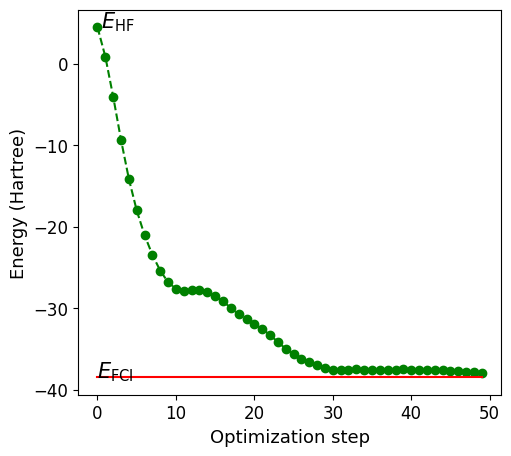

In [13]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

num_data_points = len(results["theta_param"])

# Full configuration interaction (FCI) energy computed classically
E_fci = dataset[0].fci_energy

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(0, num_data_points), results["energy_expectation_value"], "go", ls="dashed")
ax1.plot(range(0, num_data_points), np.full(num_data_points, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, results["energy_expectation_value"][0], r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, E_fci, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# DFT testing

In [ ]:
from pyscf import gto, dft, ao2mo
from openfermion import FermionOperator, get_fermion_operator
from openfermion.transforms import jordan_wigner
import pennylane as qml
import numpy as np

# Define the molecule
mol = gto.Mole()
mol.atom = 'H 0 0 0; H 0 0 0.74'
mol.basis = 'sto-3g'
mol.build()

# Perform DFT calculation with LDA
mf = dft.RKS(mol)
mf.xc = 'lda'
mf.kernel()

# Extract Kohn-Sham orbitals
ks_orbitals = mf.mo_coeff

# Compute one-electron integrals (kinetic + potential energy) in MO basis
hcore = mf.get_hcore()
h1_mo = np.dot(ks_orbitals.T, np.dot(hcore, ks_orbitals))

# Compute two-electron integrals in AO basis and transform to MO basis
eri_ao = ao2mo.kernel(mol, ks_orbitals)
eri_mo = ao2mo.restore(1, eri_ao, mol.nao_nr())

# Number of orbitals
n_orbitals = ks_orbitals.shape[1]

# Create the Hamiltonian as a FermionOperator
second_quantized_hamiltonian = FermionOperator()

# Add one-electron terms
for i in range(n_orbitals):
    for j in range(n_orbitals):
        if i <= j:  # Only include each term once
            second_quantized_hamiltonian += FermionOperator(((i, 1), (j, 0)), h1_mo[i, j])

# Add two-electron terms
for i in range(n_orbitals):
    for j in range(n_orbitals):
        for k in range(n_orbitals):
            for l in range(n_orbitals):
                if i <= j and k <= l:  # Avoid double-counting
                    hijkl = eri_mo[i, j, k, l] - eri_mo[i, j, l, k]
                    if hijkl != 0:
                        term = FermionOperator(((i, 1), (j, 1), (l, 0), (k, 0)), 0.5 * hijkl)
                        term += FermionOperator(((i, 1), (k, 1), (l, 0), (j, 0)), 0.5 * hijkl)
                        second_quantized_hamiltonian += term

# Apply Jordan-Wigner transformation to map Fermionic Hamiltonian to Pauli strings
pauli_hamiltonian = jordan_wigner(second_quantized_hamiltonian)

pennylane_hamiltonian = qml.import_operator(pauli_hamiltonian)
pennylane_hamiltonian


In [1]:
from pyscf import gto, dft, ao2mo
from openfermion import FermionOperator, get_fermion_operator
from openfermion.transforms import jordan_wigner
import pennylane as qml
import numpy as np

# Define the molecule
mol = gto.Mole()
mol.atom = 'H 0 0 0; H 0 0 0.74'
mol.basis = 'sto-3g'
mol.build()

# Perform DFT calculation with LDA
mf = dft.RKS(mol)
# mf.xc = 'HF*0.0 + LDA*0.0 + B88*0.0, LYP*0.0 + VWN*0.0'
mf.xc = 'HF*0.2 + .08*LDA + .72*B88, .81*LYP + .19*VWN'
# mf.xc = "lda"
print("Exchange correlation functional", mf.xc)
mf.kernel()

# All steps are handled by DFT calculations, we just have to convert to MO basis and create second quanitsed hamiltonian

# Extract Kohn-Sham orbitals
ks_orbitals = mf.mo_coeff
print("Kohn sham orbitals/ coefficients of atomic orbitals for molecular orbitals", ks_orbitals)

# Compute one-electron integrals (kinetic + potential energy) in MO basis
hcore = mf.get_hcore()
print("Hamiltonian", hcore)
h1_mo = np.dot(ks_orbitals.T, np.dot(hcore, ks_orbitals))

# Compute two-electron integrals in AO basis and transform to MO basis
eri_ao = ao2mo.kernel(mol, ks_orbitals)
eri_mo = ao2mo.restore(1, eri_ao, mol.nao_nr())

# Number of orbitals
n_orbitals = ks_orbitals.shape[1]

# Create the Hamiltonian as a FermionOperator
second_quantized_hamiltonian = FermionOperator()

# Add one-electron terms
for i in range(n_orbitals):
    for j in range(n_orbitals):
        if i <= j:  # Only include each term once
            second_quantized_hamiltonian += FermionOperator(((i, 1), (j, 0)), h1_mo[i, j])

# Add two-electron terms
for i in range(n_orbitals):
    for j in range(n_orbitals):
        for k in range(n_orbitals):
            for l in range(n_orbitals):
                if i <= j and k <= l:  # Avoid double-counting
                    hijkl = eri_mo[i, j, k, l] - eri_mo[i, j, l, k]
                    if hijkl != 0:
                        term = FermionOperator(((i, 1), (j, 1), (l, 0), (k, 0)), 0.5 * hijkl)
                        term += FermionOperator(((i, 1), (k, 1), (l, 0), (j, 0)), 0.5 * hijkl)
                        second_quantized_hamiltonian += term

# Apply Jordan-Wigner transformation to map Fermionic Hamiltonian to Pauli strings
pauli_hamiltonian = jordan_wigner(second_quantized_hamiltonian)

pennylane_hamiltonian = qml.import_operator(pauli_hamiltonian)
# pennylane_hamiltonian


Exchange correlation functional HF*0.2 + .08*LDA + .72*B88, .81*LYP + .19*VWN
converged SCF energy = -1.15861747506767
Kohn sham orbitals/ coefficients of atomic orbitals for molecular orbitals [[ 0.54884228  1.21245192]
 [ 0.54884228 -1.21245192]]
Hamiltonian [[-1.12095946 -0.95937577]
 [-0.95937577 -1.12095946]]
